In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.4 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install gdown

In [3]:
!gdown --id "19wOGJrT-d_xkzWAO2IvgRrHUYWrIn7CC"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19wOGJrT-d_xkzWAO2IvgRrHUYWrIn7CC
From (redirected): https://drive.google.com/uc?id=19wOGJrT-d_xkzWAO2IvgRrHUYWrIn7CC&confirm=t&uuid=3816b2f4-d3d1-4003-aea7-1109f56b368c
To: /kaggle/working/Train.csv
100%|███████████████████████████████████████| 1.07G/1.07G [00:10<00:00, 103MB/s]


In [4]:
!gdown --id  "1mudZNxWPfCfAjdfwNfwGIzBHNv6wjUoG" 

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mudZNxWPfCfAjdfwNfwGIzBHNv6wjUoG
From (redirected): https://drive.google.com/uc?id=1mudZNxWPfCfAjdfwNfwGIzBHNv6wjUoG&confirm=t&uuid=b1980ff6-ec2a-44dc-a0e5-91620ddae1fd
To: /kaggle/working/Test.csv
100%|████████████████████████████████████████| 697M/697M [00:07<00:00, 91.3MB/s]


In [5]:
!gdown --id "10tR1N2JRI98pJrDv94Sj1Zm53R6VFf7n"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10tR1N2JRI98pJrDv94Sj1Zm53R6VFf7n
To: /kaggle/working/SampleSubmission.csv
100%|████████████████████████████████████████| 224k/224k [00:00<00:00, 83.7MB/s]


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import lightgbm as lgb
import optuna
import xgboost as xgb
import numpy as np
import catboost as cb

In [219]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATA_DIR = "/kaggle/working"

In [221]:
# Load files
train_df = pd.read_csv(DATA_DIR + '/Train.csv')
test_df = pd.read_csv(DATA_DIR + '/Test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/SampleSubmission.csv')


In [222]:
# Preview train file
train_df.head()

,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target
0,1D_0000,2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1D_0000,2021-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1D_0000,2021-01-14,0.0845,0.1030,0.0583,0.1977,0.1152,0.0464,0.0742,0.1326,0.1682,0.2243,0.2500,0.0347,0.0007,0.544531,0.263663,-0.401134,0.120000,0.0
3,1D_0000,2021-01-19,0.1095,0.1357,0.0858,0.1596,0.0782,0.0330,0.0873,0.1620,0.1396,0.1736,0.1820,0.0260,0.0011,0.300733,0.342304,-0.186176,0.008666,0.0
4,1D_0000,2021-01-24,0.1128,0.1300,0.0919,0.2141,0.1240,0.0608,0.1035,0.1546,0.1845,0.2302,0.2606,0.0703,0.0041,0.399346,0.266489,-0.309881,0.059365,0.0


View on row of the data as an RGB image, what happens if you add more layers to this image? Does this give you an idea of how tabular data can be turned into image data and vice versa?

In [223]:
train_df.sort_values(by=['ID'])

,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target
0,1D_0000,2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
177,1D_0000,2023-06-08,0.4178,0.4388,0.4105,0.4846,0.3239,0.2089,0.3798,0.4197,0.4449,0.5062,0.5364,0.0914,0.0084,0.082784,0.198763,-0.074025,-0.038846,0.0
178,1D_0000,2023-06-13,0.1229,0.1391,0.0972,0.3416,0.2005,0.1116,0.1368,0.1867,0.2771,0.3659,0.4141,0.0689,0.0007,0.556974,0.260284,-0.470829,0.169231,0.0
179,1D_0000,2023-06-18,0.2705,0.2995,0.2393,0.3743,0.2186,0.1229,0.2282,0.2668,0.2963,0.3484,0.3618,0.0539,0.0023,0.220013,0.262608,-0.160980,-0.023743,0.0
180,1D_0000,2023-06-23,0.7293,0.7446,0.7718,0.7480,0.5132,0.3589,0.7287,0.7343,0.7572,0.8280,0.8548,0.1384,0.0014,-0.015660,0.186172,-0.012658,-0.028724,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7552485,id_35de00e2a,2022-04-04,0.6719,0.7056,0.6939,0.7287,0.1527,0.1710,0.6989,0.7224,0.7246,0.7464,0.7501,0.5046,0.1527,0.024462,0.653506,-0.040554,0.003590,1.0
7552486,id_35de00e2a,2022-04-09,0.0945,0.1004,0.0634,0.2846,0.1783,0.0795,0.0981,0.1264,0.2353,0.2991,0.3382,0.0539,0.0080,0.635632,0.229639,-0.501451,0.214861,1.0
7552487,id_35de00e2a,2022-04-14,0.2075,0.2260,0.1840,0.3547,0.2703,0.1690,0.2144,0.2425,0.3278,0.3892,0.4208,0.0577,0.0054,0.316874,0.135040,-0.261829,0.076305,1.0
7552457,id_35de00e2a,2021-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [224]:
# Preview test file
test_df.head()

,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI
0,1D_0005,2021-01-04,0.1199,0.1391,0.0978,0.2329,0.1782,0.0989,0.1146,0.2127,0.2074,0.2675,0.3081,0.0503,0.0011,0.408527,0.133058,-0.320295,0.079096
1,1D_0005,2021-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1D_0005,2021-01-14,0.0818,0.1010,0.0563,0.1848,0.1139,0.0459,0.0756,0.1324,0.1687,0.2246,0.2513,0.0372,0.0007,0.532974,0.237362,-0.386347,0.146323
3,1D_0005,2021-01-19,0.1270,0.1581,0.1031,0.1899,0.1186,0.0583,0.1124,0.1763,0.1639,0.1987,0.2156,0.0298,0.0012,0.296246,0.231118,-0.198485,0.043155
4,1D_0005,2021-01-24,0.1122,0.1311,0.0916,0.2125,0.1259,0.0608,0.1060,0.1553,0.1840,0.2307,0.2611,0.0709,0.0046,0.397567,0.255910,-0.308901,0.072874


In [225]:
train_df['time'] = pd.to_datetime(train_df['time'])

In [226]:
test_df['time'] = pd.to_datetime(test_df['time'])

In [227]:
train_df.sort_values(by=['time'], inplace=True), test_df.sort_values(by=['time'], inplace=True)

(None, None)

In [228]:
numeric_cols = train_df.select_dtypes(include=['number']).columns
non_numeric_cols = train_df.columns.difference(numeric_cols)
non_numeric_cols

Index(['ID', 'time'], dtype='object')

In [ ]:
def fill_and_compute_mean(x):
    x = np.array(x, dtype=np.float64)
    x_filled = pd.Series(x).fillna(0)
    return np.mean(x_filled) if not x_filled.empty else np.nan

In [ ]:
grouped_numeric = (
    train_df.groupby(['ID'])[numeric_cols]
    .agg(lambda x: fill_and_compute_mean(x))
)

# Process non-numeric columns
grouped_non_numeric = (
    train_df.groupby(['ID'])[non_numeric_cols]
    .first()
)

# Drop 'Target' from grouped_non_numeric to prevent duplication

if 'ID' in grouped_non_numeric.columns:
    grouped_non_numeric = grouped_non_numeric.drop(columns=['ID'])

    
if 'ID' in grouped_numeric.columns:
    grouped_numeric = grouped_numeric.drop(columns=['ID'])

grouped_numeric.reset_index(inplace=True)
grouped_non_numeric.reset_index(inplace=True)

grouped_df = grouped_numeric.merge(grouped_non_numeric)
grouped_df.head()

,ID,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target,time
0,1D_0000,0.179226,0.192814,0.174988,0.247375,0.164097,0.102160,0.177353,0.206961,0.229520,0.268961,0.287639,0.058988,0.006737,0.203976,0.155970,-0.164013,0.034932,0.0,2021-01-04
1,1D_0001,0.186081,0.199406,0.181797,0.261344,0.173412,0.107830,0.184359,0.212978,0.239588,0.281021,0.300872,0.060530,0.006953,0.207633,0.158152,-0.170974,0.033612,0.0,2021-01-04
2,1D_0002,0.179296,0.193135,0.175780,0.246819,0.164577,0.103219,0.178170,0.206961,0.229422,0.268283,0.287099,0.058988,0.006737,0.201711,0.154458,-0.163458,0.033323,0.0,2021-01-04
3,1D_0003,0.179419,0.192935,0.176162,0.243558,0.164577,0.103219,0.178170,0.206961,0.229422,0.268283,0.287099,0.058988,0.006737,0.195351,0.147674,-0.157081,0.032421,0.0,2021-01-04
4,1D_0004,0.180501,0.193852,0.176792,0.246078,0.165256,0.103836,0.179026,0.207461,0.230830,0.270123,0.288320,0.059564,0.006702,0.196981,0.149506,-0.157615,0.033973,0.0,2021-01-04


In [ ]:
numeric_cols = list(numeric_cols)
if 'Target' in numeric_cols:
    numeric_cols.remove('Target')
    
grouped_numeric = (
    test_df.groupby(['ID'])[numeric_cols]
    .agg(lambda x: fill_and_compute_mean(x))
)

# Process non-numeric columns
grouped_non_numeric = (
    test_df.groupby(['ID'])[non_numeric_cols]
    .first()
)

if 'ID' in grouped_non_numeric.columns:
    grouped_non_numeric = grouped_non_numeric.drop(columns=['ID'])

if 'ID' in grouped_numeric.columns:
    grouped_numeric = grouped_numeric.drop(columns=['ID'])

grouped_numeric.reset_index(inplace=True)
grouped_non_numeric.reset_index(inplace=True)

grouped_test_df = grouped_numeric.merge(grouped_non_numeric)
grouped_test_df.head()



,ID,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,time
0,1D_0005,0.186479,0.200169,0.182910,0.249789,0.173662,0.109479,0.185567,0.215495,0.236827,0.276158,0.294777,0.060891,0.007071,0.192322,0.140391,-0.154085,0.034744,2021-01-04
1,1D_000A,0.184879,0.197747,0.180995,0.271525,0.176194,0.108738,0.185024,0.211424,0.246368,0.291035,0.312429,0.061422,0.006787,0.222426,0.163788,-0.187343,0.041665,2021-01-04
2,1D_000D,0.185933,0.199909,0.182308,0.254908,0.173477,0.108609,0.184247,0.214263,0.237067,0.277334,0.296622,0.061171,0.006846,0.200128,0.145634,-0.163132,0.031997,2021-01-04
3,1D_000E,0.188152,0.200142,0.183830,0.265904,0.173326,0.107401,0.186566,0.212097,0.241531,0.281453,0.300541,0.060978,0.006823,0.206584,0.162737,-0.170188,0.034180,2021-01-04
4,1D_0015,0.191770,0.203478,0.187791,0.282226,0.183726,0.114668,0.192300,0.216365,0.256846,0.302786,0.324804,0.062177,0.006853,0.223782,0.165152,-0.187955,0.044347,2021-01-04


In [232]:
grouped_df.dropna(axis=0, inplace=True)
grouped_test_df.dropna(axis=0, inplace=True)

In [233]:
X = grouped_df
X_test = grouped_test_df

## **Explore**

<!-- ## Feature Engineering -->

In [234]:
X.describe()

,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target,time
count,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,26170
mean,0.185418,0.196874,0.180384,0.267519,0.185096,0.117013,0.186877,0.212110,0.249105,0.288156,0.307988,0.068664,0.013544,0.209073,0.130277,-0.175016,0.043547,0.895109,2021-01-01 13:20:49.889185792
min,0.000579,0.000634,0.000487,0.000992,0.000599,0.000351,0.000534,0.000763,0.000887,0.001075,0.001168,0.000207,0.000067,0.000249,-0.091069,-0.271925,-0.039901,0.000000,2021-01-01 00:00:00
25%,0.180714,0.192239,0.174590,0.262351,0.178220,0.112071,0.181499,0.207363,0.244532,0.282575,0.302129,0.065810,0.011856,0.197172,0.121476,-0.184660,0.036798,0.000000,2021-01-01 00:00:00
50%,0.187350,0.198940,0.181819,0.269975,0.185850,0.116701,0.188203,0.214312,0.251613,0.291021,0.311023,0.067907,0.013179,0.209440,0.135265,-0.174160,0.042819,1.000000,2021-01-01 00:00:00
75%,0.192624,0.204452,0.187797,0.276918,0.192307,0.121519,0.193786,0.219540,0.257663,0.298243,0.318638,0.070903,0.015120,0.222493,0.147861,-0.165082,0.049255,2.000000,2021-01-01 00:00:00
max,0.221075,0.229739,0.230182,0.312363,0.267456,0.205617,0.227765,0.239868,0.284643,0.332384,0.357754,0.085568,0.023342,0.318526,0.197969,-0.000338,0.107743,2.000000,2021-01-04 00:00:00
std,0.013999,0.014898,0.013999,0.019414,0.015066,0.010747,0.013456,0.015098,0.017571,0.020909,0.022340,0.005632,0.002545,0.026722,0.032047,0.020474,0.010826,0.891043,NaN


In [235]:
X_test.describe()

,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,time
count,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960.000000,16960
mean,0.184869,0.196196,0.179765,0.267560,0.185112,0.116978,0.186553,0.211305,0.248986,0.287944,0.308039,0.068848,0.013541,0.210530,0.130305,-0.176175,0.044991,2021-01-01 19:09:11.886792704
min,0.000579,0.000634,0.000487,0.001026,0.000612,0.000351,0.000534,0.000763,0.000904,0.001128,0.001223,0.000208,0.000068,0.000241,-0.094944,-0.256623,-0.018195,2021-01-01 00:00:00
25%,0.179997,0.191342,0.173886,0.261973,0.178526,0.112190,0.181170,0.206244,0.244349,0.282131,0.301853,0.065919,0.011815,0.198308,0.121502,-0.186220,0.037732,2021-01-01 00:00:00
50%,0.186546,0.197956,0.181135,0.269779,0.185924,0.116704,0.187773,0.212932,0.251109,0.290371,0.310594,0.067894,0.012709,0.209854,0.134248,-0.174482,0.044477,2021-01-01 00:00:00
75%,0.192239,0.204149,0.187292,0.276938,0.191933,0.121312,0.193476,0.219083,0.257439,0.298015,0.318770,0.070905,0.014529,0.224075,0.147535,-0.165783,0.051170,2021-01-04 00:00:00
max,0.221075,0.229739,0.230182,0.308416,0.264142,0.187440,0.226849,0.238971,0.284084,0.331453,0.356587,0.085568,0.023342,0.302433,0.197969,-0.000308,0.105584,2021-01-04 00:00:00
std,0.014028,0.014943,0.014059,0.019506,0.014829,0.010593,0.013449,0.015156,0.017553,0.020946,0.022421,0.005865,0.002853,0.027214,0.032078,0.020870,0.011242,NaN


In [236]:
X.isna().sum()

ID             0
Green          0
Blue           0
RED            0
NIR            0
SWIR1          0
SWIR2          0
Red_Edge       0
Aerosols       0
Red_Edge_2     0
Red_Edge_3     0
Red_Edge_4     0
Water_vapor    0
Cirrus         0
NDVI           0
NDMI           0
NDWI           0
CI             0
Target         0
time           0
dtype: int64

In [ ]:
X["Moisture_Index"] = (X["NIR"] - X["SWIR1"]) / (X["NIR"] + X["SWIR1"])
X["Agriculture_Index"] = (X["SWIR1"] - X["Blue"]) / (X["SWIR1"] + X["Blue"])

In [ ]:
X_test["Moisture_Index"] = (X_test["NIR"] - X_test["SWIR1"]) / (X_test["NIR"] + X_test["SWIR1"])
X_test["Agriculture_Index"] = (X_test["SWIR1"] - X_test["Blue"]) / (X_test["SWIR1"] + X_test["Blue"])

In [239]:
numeric_cols = X.select_dtypes(include=['number']).columns.to_list()
non_numeric_cols = X.select_dtypes(exclude=['number']).columns

In [240]:
if 'Target' in numeric_cols:
    numeric_cols.remove('Target')

In [241]:
print(numeric_cols)

['Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge', 'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor', 'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'Moisture_Index', 'Agriculture_Index']


In [242]:
print(non_numeric_cols)

Index(['ID', 'time'], dtype='object')


In [243]:
def view_bar_graph(X):
    num_cols = len(numeric_cols)
    cols_per_row = 4  # Number of plots per row
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(15, rows * 4))
    axes = axes.flatten()
    
    for i, c in enumerate(numeric_cols):
        X[c].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'Histogram of {c}')
    
    for i in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[i])  # Remove empty subplots
    
    plt.tight_layout()
    plt.show()

In [244]:
def view_box_plot(X):
    num_cols = len(numeric_cols)
    cols_per_row = 4  # Number of plots per row
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)  # Calculate required rows
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(15, rows * 4))
    
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for i, c in enumerate(numeric_cols):
        X[c].plot(kind='box', ax=axes[i])  # Box plot for each column
        axes[i].set_title(f'Boxplot of {c}')
    
    # Remove any empty subplots
    for i in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

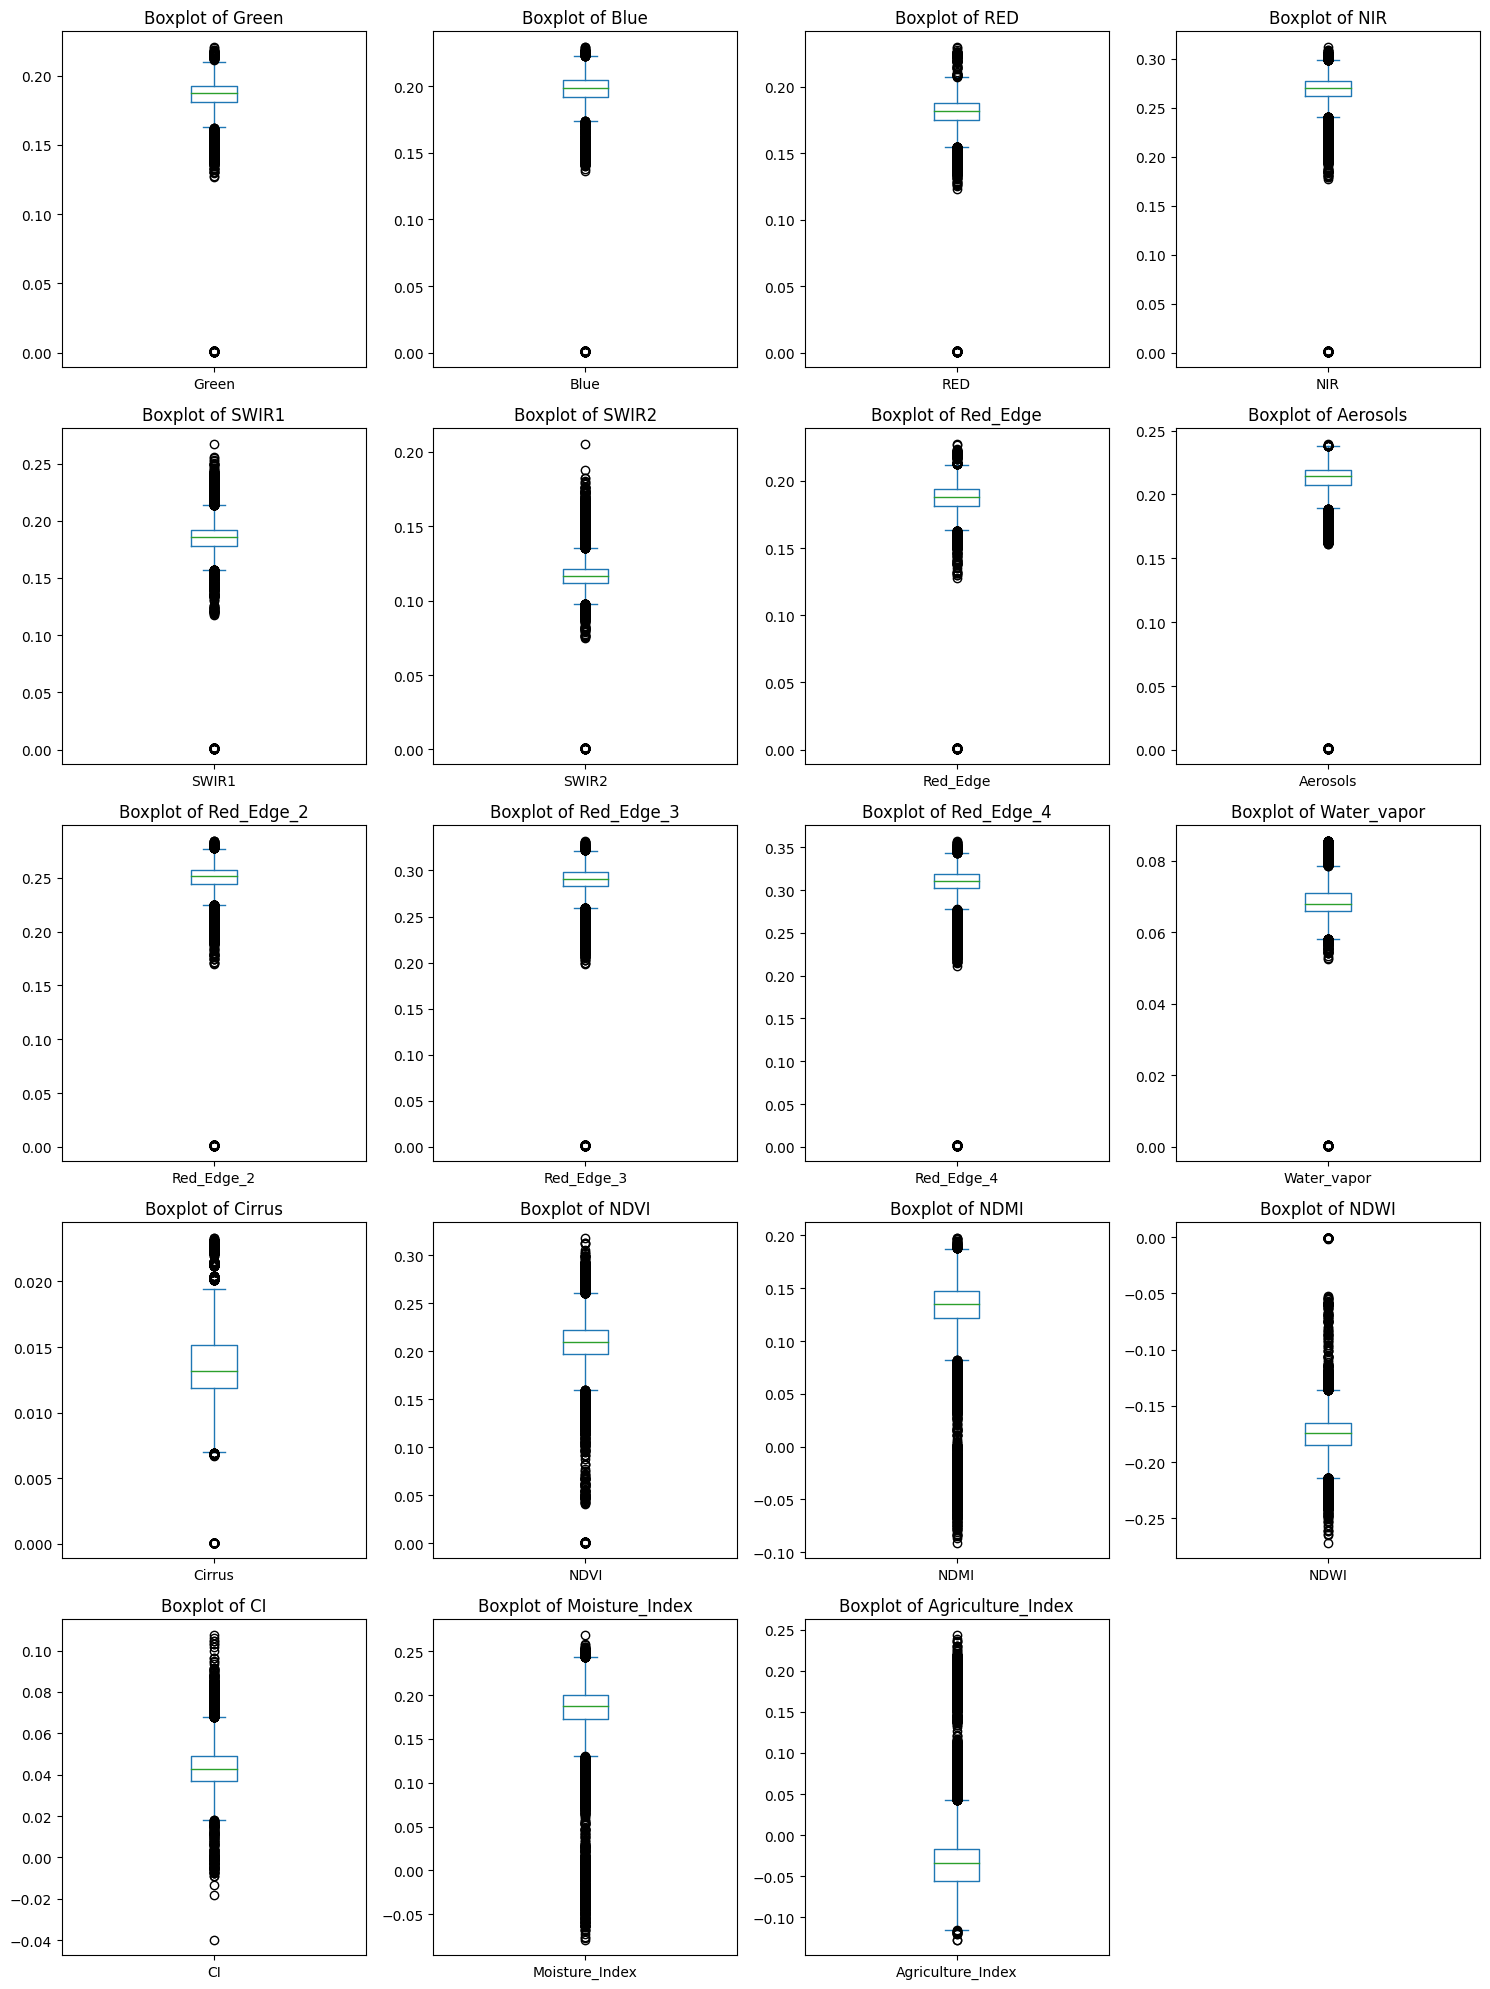

In [245]:
view_box_plot(X)

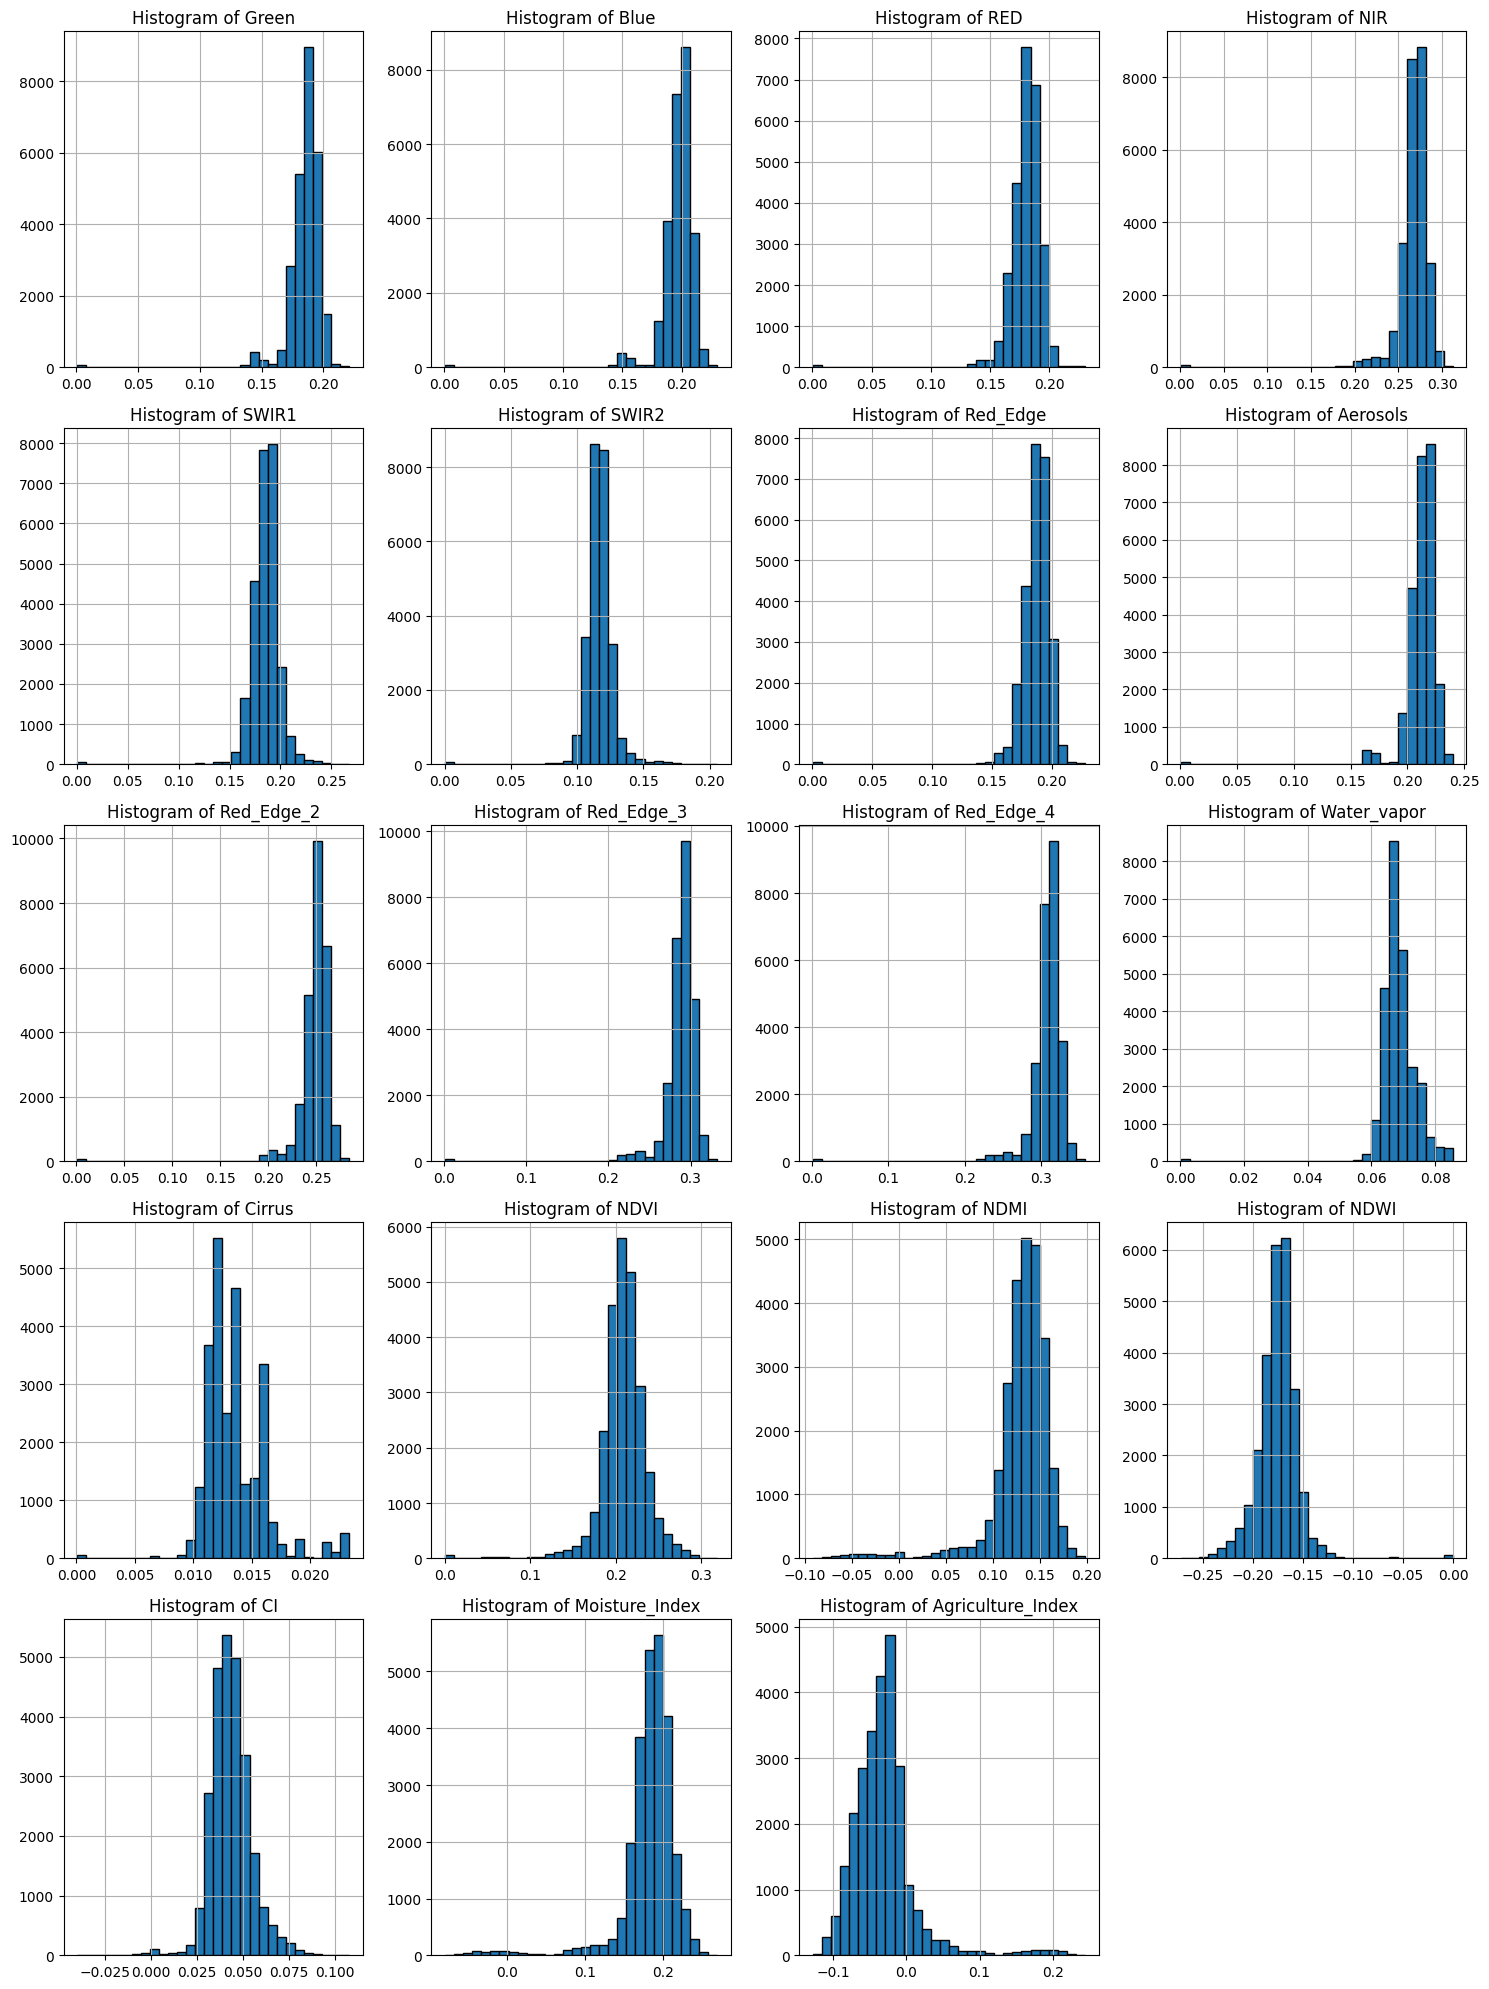

In [246]:
view_bar_graph(X)

In [247]:
def compute_train_iqr(X_train):
    """Compute IQR values from the training data with adaptive thresholds."""
    iqr_values = {}

    for col in numeric_cols:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1

        # Adaptive multiplier: More tolerant for skewed data
        skewness = X_train[col].skew()
        multiplier = 1.5 if abs(skewness) < 1 else 3  

        iqr_values[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "lower_bound": Q1 - multiplier * IQR,
            "upper_bound": Q3 + multiplier * IQR
        }
    return iqr_values

    


def adjust_outliers(X, iqr_values):
    """Replace outliers with a smoothly transformed version using sigmoid scaling."""
    X = X.copy()

    for col, iqr in iqr_values.items():
        lower_bound, upper_bound = iqr["lower_bound"], iqr["upper_bound"]
        IQR = iqr["IQR"]

        # Sigmoid-like smoothing for outliers
        X[col] = np.where(
            X[col] < lower_bound,
            lower_bound + (X[col] - lower_bound) / (1 + np.abs(X[col] - lower_bound) / IQR),
            np.where(
                X[col] > upper_bound,
                upper_bound - (X[col] - upper_bound) / (1 + np.abs(X[col] - upper_bound) / IQR),
                X[col]
            )
        )
    return X


In [248]:
iqr_values = compute_train_iqr(X)

# Step 2: Adjust outliers in both train and test sets
X = adjust_outliers(X, iqr_values)
X_test = adjust_outliers(X_test, iqr_values)

In [251]:
X_test.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'time', 'Moisture_Index',
       'Agriculture_Index'],
      dtype='object')

In [252]:
X.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'Target', 'time',
       'Moisture_Index', 'Agriculture_Index'],
      dtype='object')

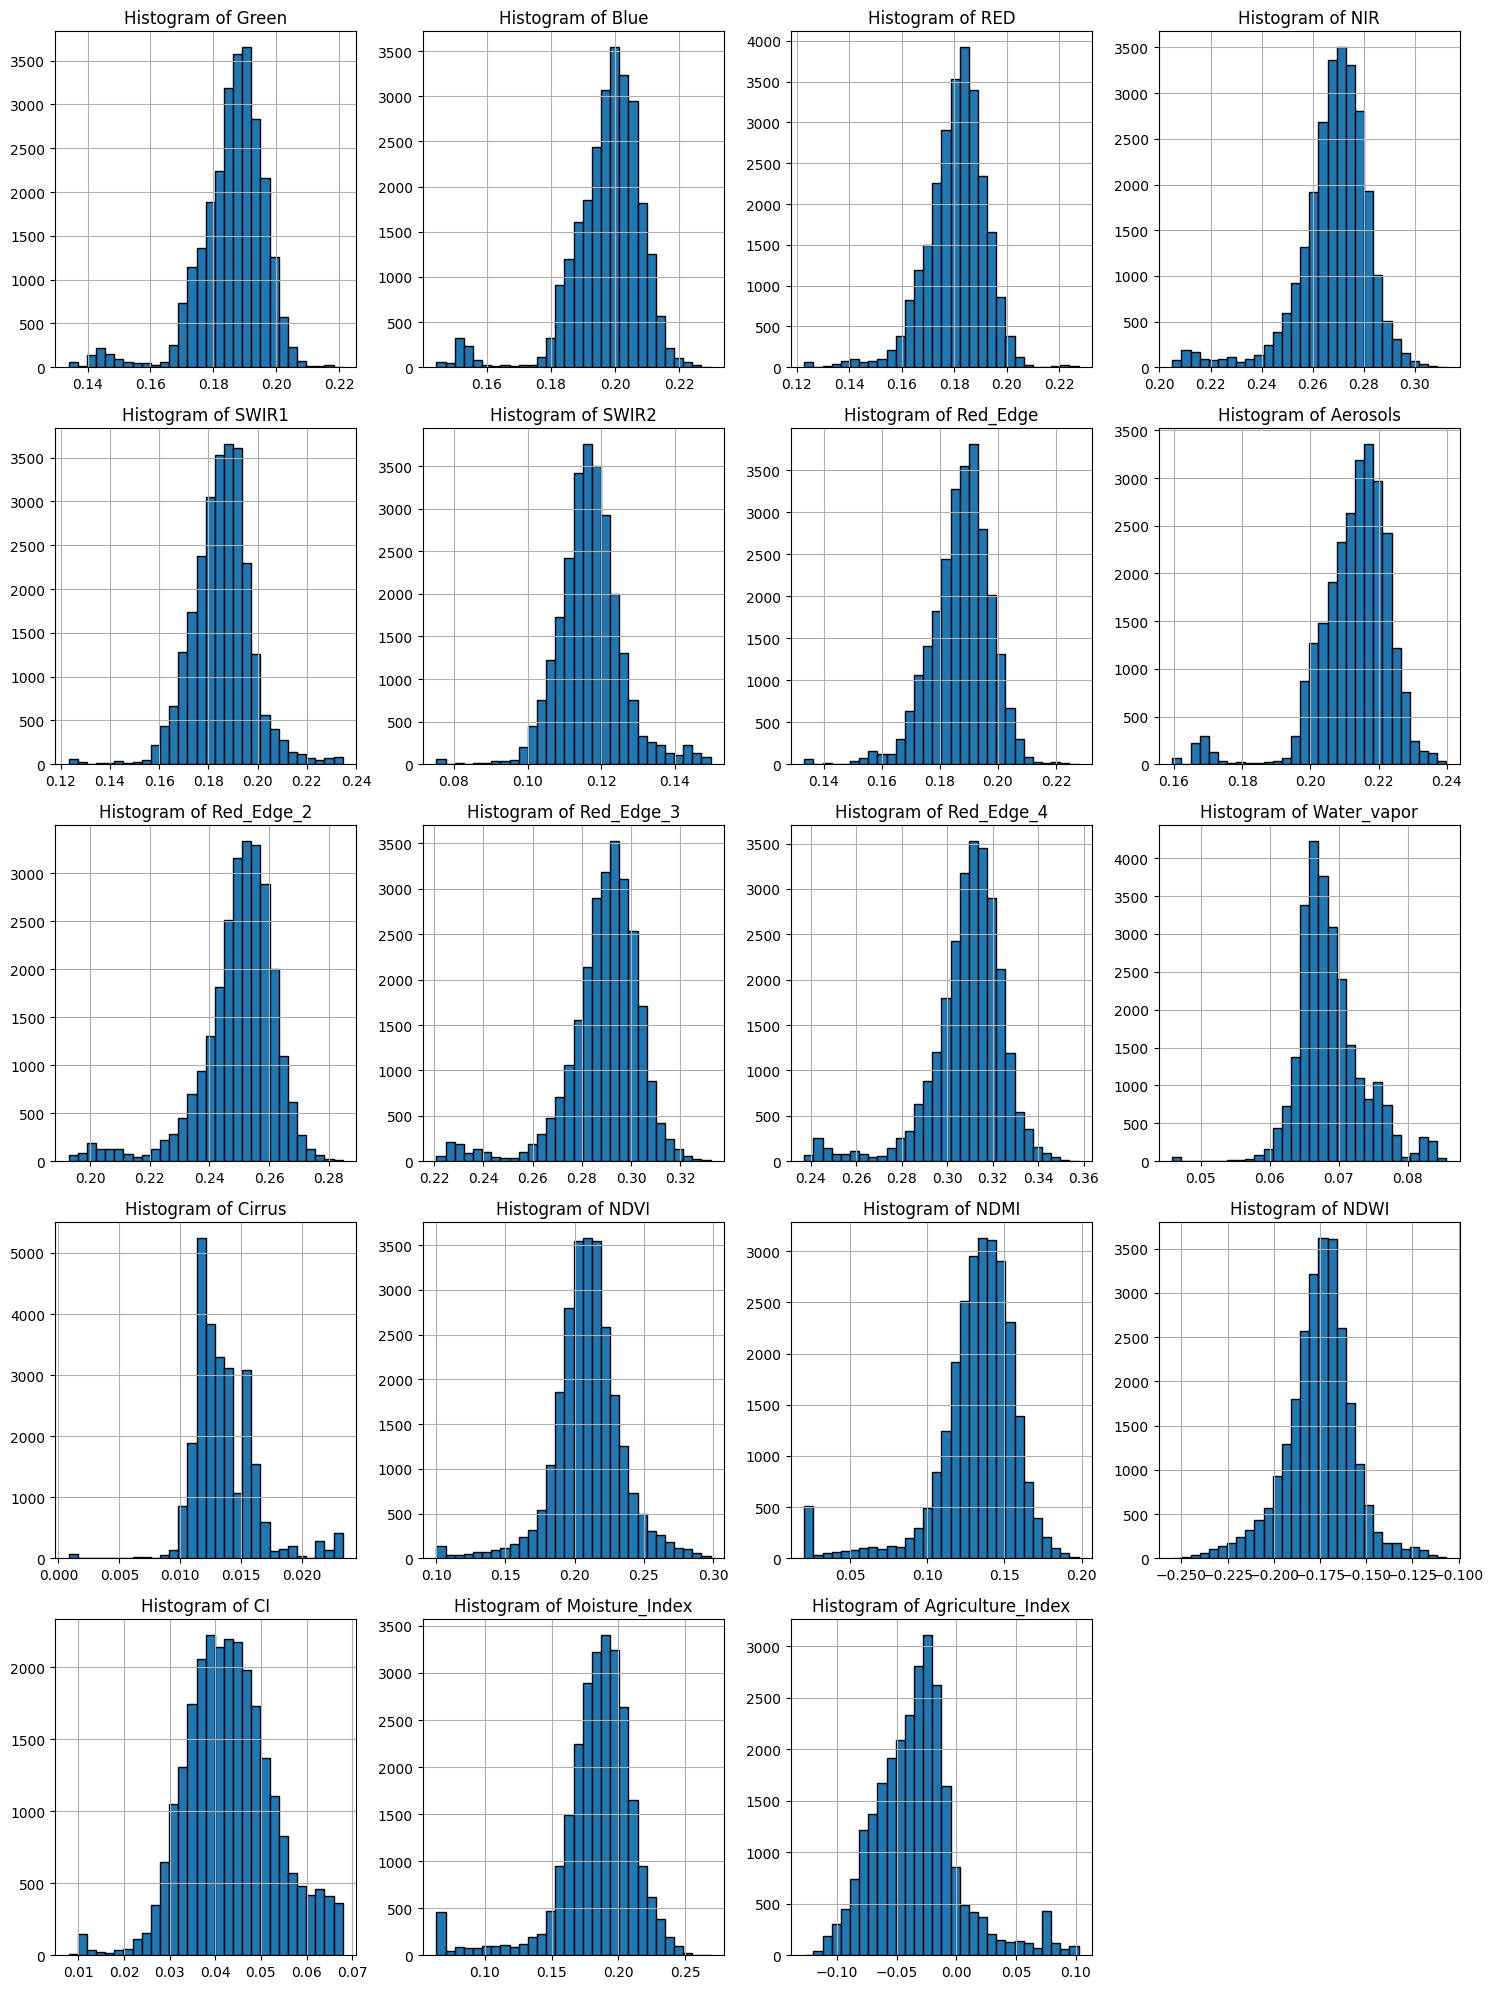

In [253]:
view_bar_graph(X)

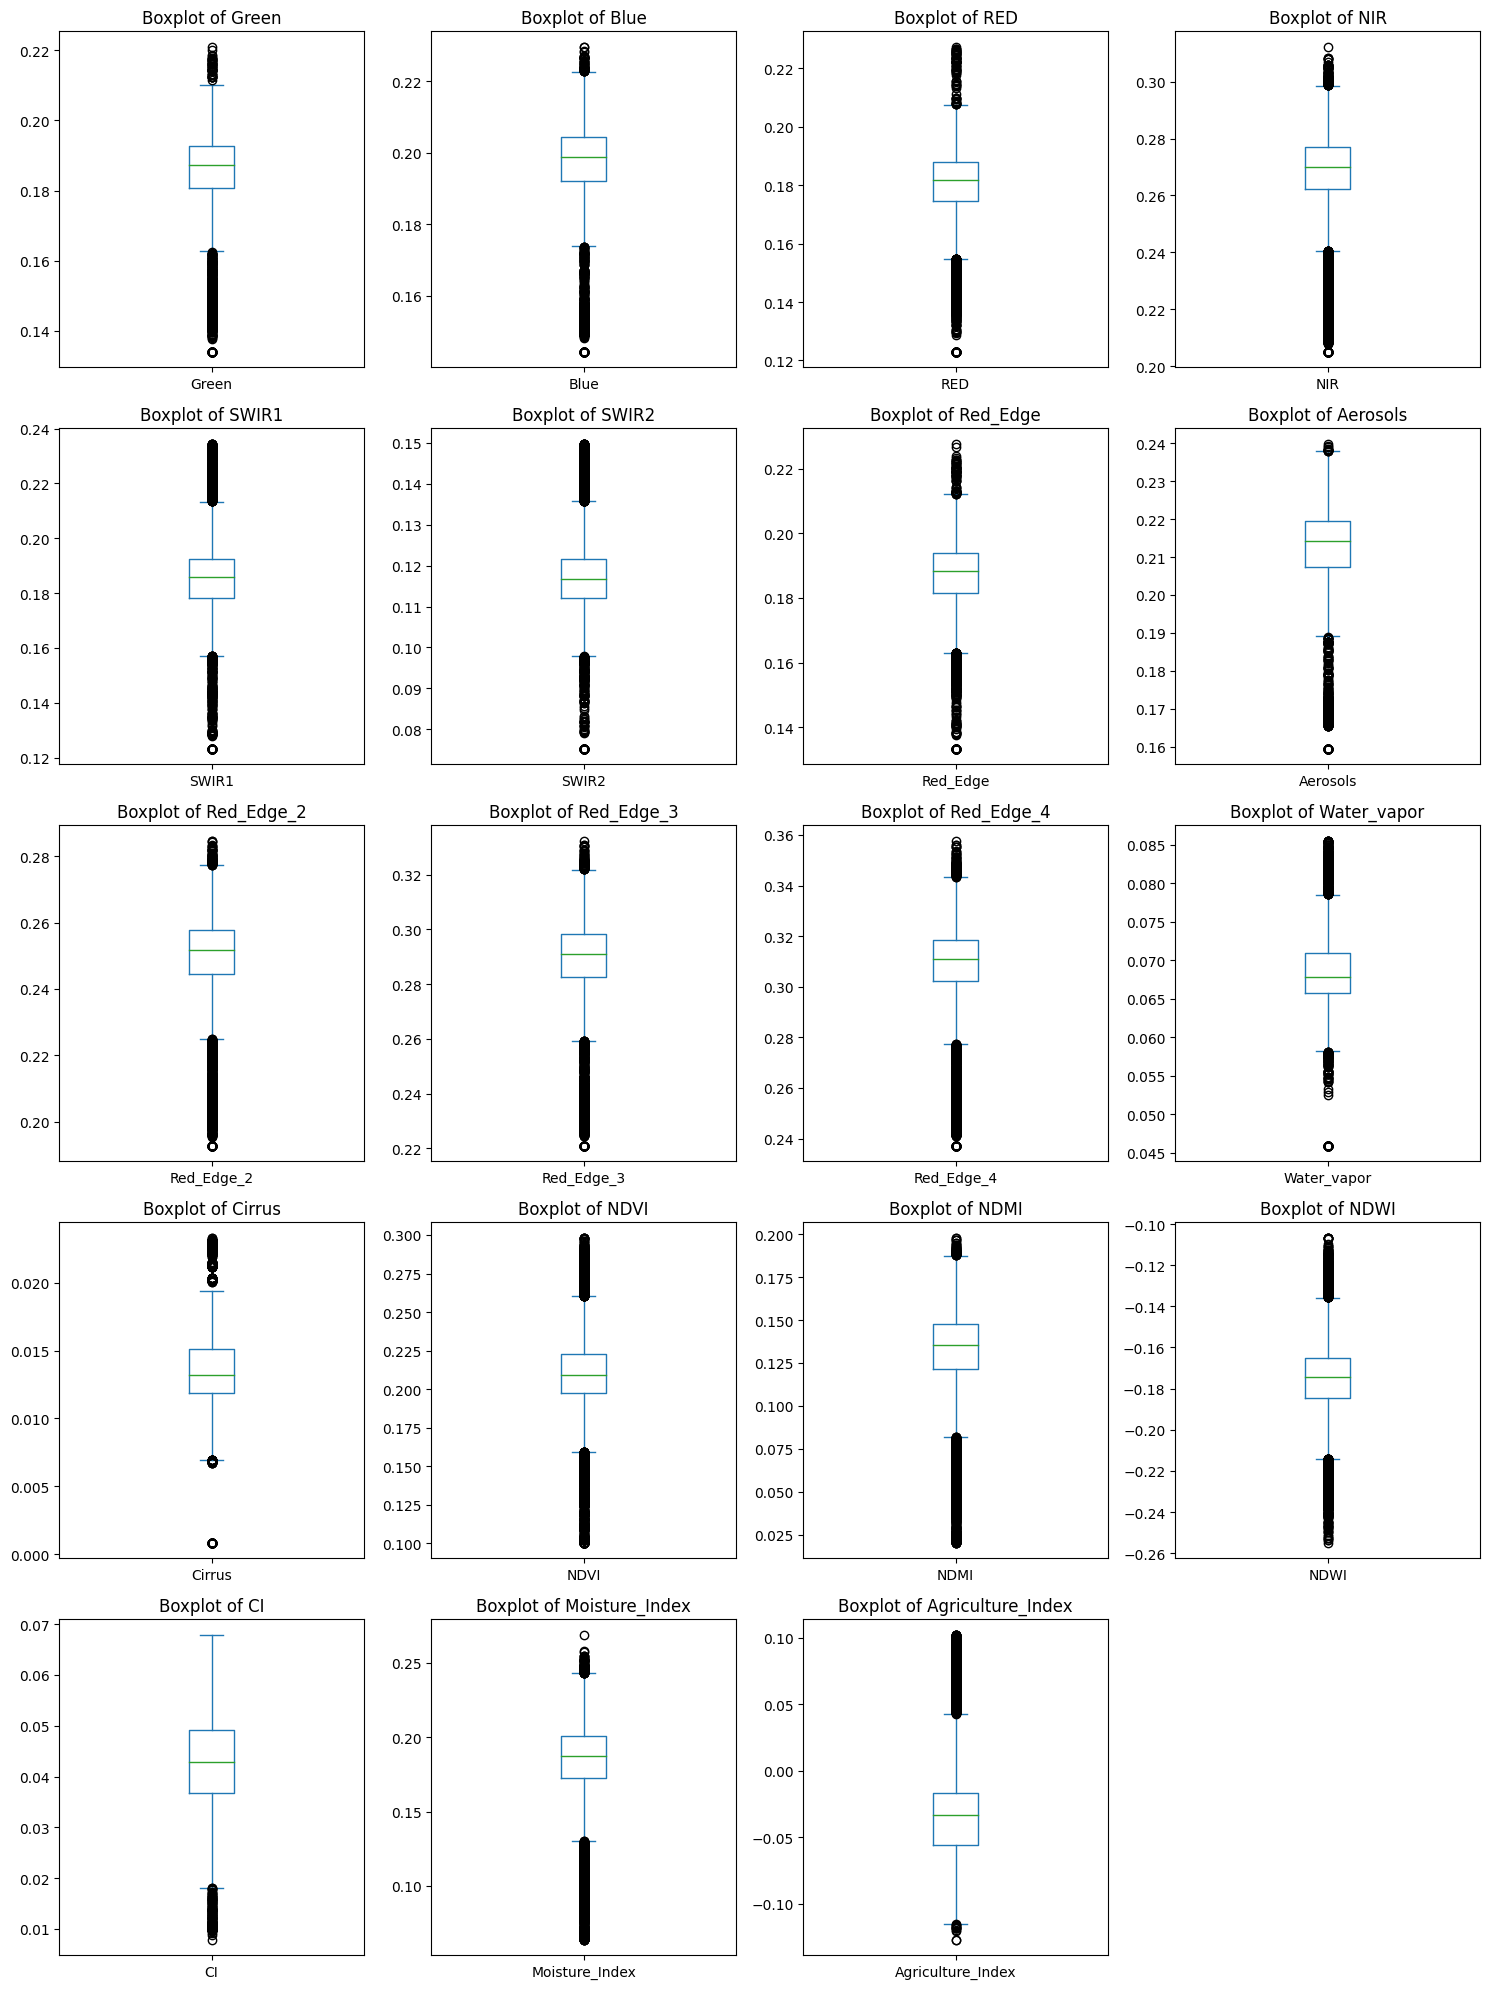

In [254]:
view_box_plot(X)

                      Green      Blue       RED       NIR     SWIR1     SWIR2  \
Green              1.000000  0.989454  0.966118  0.735420  0.190508  0.208584   
Blue               0.989454  1.000000  0.938870  0.716622  0.088185  0.108343   
RED                0.966118  0.938870  1.000000  0.614557  0.297867  0.352767   
NIR                0.735420  0.716622  0.614557  1.000000  0.310729  0.189052   
SWIR1              0.190508  0.088185  0.297867  0.310729  1.000000  0.955756   
SWIR2              0.208584  0.108343  0.352767  0.189052  0.955756  1.000000   
Red_Edge           0.950117  0.905453  0.974423  0.692466  0.428378  0.456783   
Aerosols           0.963686  0.985896  0.896651  0.714248  0.037453  0.050615   
Red_Edge_2         0.827628  0.794088  0.735899  0.964139  0.383694  0.286699   
Red_Edge_3         0.770384  0.752777  0.654965  0.982093  0.301706  0.185312   
Red_Edge_4         0.724529  0.705344  0.600475  0.982304  0.313460  0.183528   
Water_vapor        0.443316 

<Axes: >

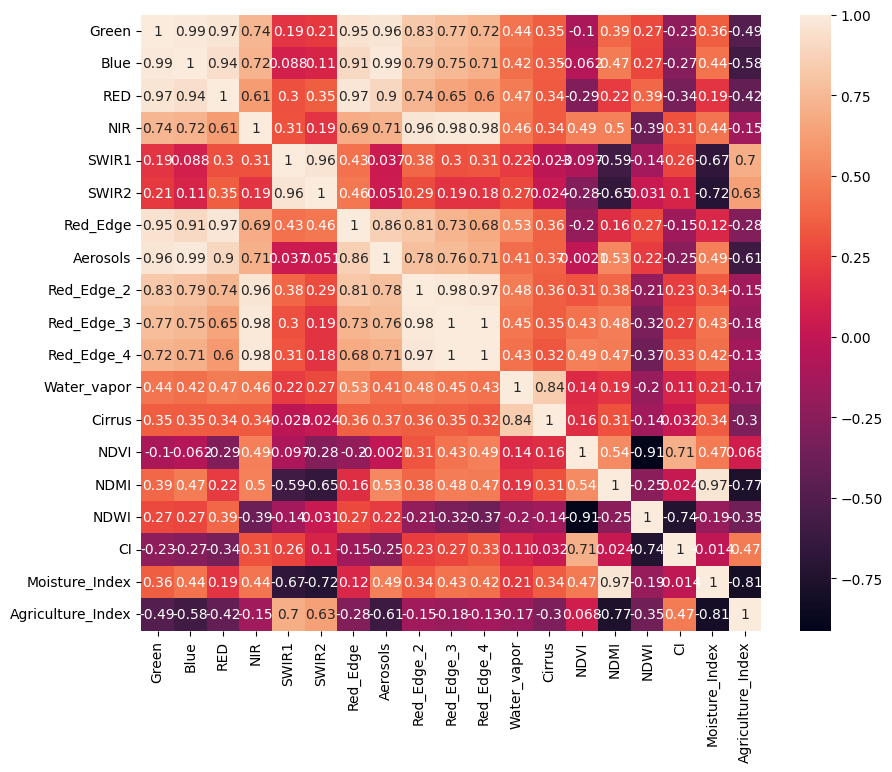

In [255]:
# X_train = X
plt.figure(figsize=(10, 8))
correlation = X[numeric_cols].corr()
print(correlation)
sns.heatmap(correlation, annot=True)

In [256]:
X_train = X 

In [261]:
X_train.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'Target', 'time',
       'Moisture_Index', 'Agriculture_Index'],
      dtype='object')

In [262]:
X_test.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'time', 'Moisture_Index',
       'Agriculture_Index'],
      dtype='object')

In [264]:
numeric_cols

['Green',
 'Blue',
 'RED',
 'NIR',
 'SWIR1',
 'SWIR2',
 'Red_Edge',
 'Aerosols',
 'Red_Edge_2',
 'Red_Edge_3',
 'Red_Edge_4',
 'Water_vapor',
 'Cirrus',
 'NDVI',
 'NDMI',
 'NDWI',
 'CI',
 'Moisture_Index',
 'Agriculture_Index',
 'ID',
 'time']

In [266]:
y_train = X_train['Target']
X_train = X_train.drop(columns=['Target'])

In [268]:
X_test.columns, X_test.dtypes

(Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
        'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
        'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'time', 'Moisture_Index',
        'Agriculture_Index'],
       dtype='object'),
 ID                           object
 Green                       float64
 Blue                        float64
 RED                         float64
 NIR                         float64
 SWIR1                       float64
 SWIR2                       float64
 Red_Edge                    float64
 Aerosols                    float64
 Red_Edge_2                  float64
 Red_Edge_3                  float64
 Red_Edge_4                  float64
 Water_vapor                 float64
 Cirrus                      float64
 NDVI                        float64
 NDMI                        float64
 NDWI                        float64
 CI                          float64
 time                 datetime64[ns]
 Moisture_Index  

In [269]:
X_train.columns, X_train.dtypes

(Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
        'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
        'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'time', 'Moisture_Index',
        'Agriculture_Index'],
       dtype='object'),
 ID                           object
 Green                       float64
 Blue                        float64
 RED                         float64
 NIR                         float64
 SWIR1                       float64
 SWIR2                       float64
 Red_Edge                    float64
 Aerosols                    float64
 Red_Edge_2                  float64
 Red_Edge_3                  float64
 Red_Edge_4                  float64
 Water_vapor                 float64
 Cirrus                      float64
 NDVI                        float64
 NDMI                        float64
 NDWI                        float64
 CI                          float64
 time                 datetime64[ns]
 Moisture_Index  

## Build Model

In [ ]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

In [271]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        'objective' : 'multiclass', 
        'num_class': 3,
    }

    model = lgb.LGBMClassifier(**params, random_state=42)

    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    
    return np.mean(scores)  # Maximize accuracy

# Run Optuna optimization
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, n_jobs=-1)

# Best parameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-28 07:34:12,353] A new study created in memory with name: no-name-82af725d-8a80-476f-ac10-3861ea972620
[I 2025-03-28 07:34:44,118] Trial 1 finished with value: 0.9087886893389377 and parameters: {'max_depth': 10, 'learning_rate': 0.015219977602412178, 'n_estimators': 150}. Best is trial 1 with value: 0.9087886893389377.
[I 2025-03-28 07:35:30,600] Trial 3 finished with value: 0.9006495987772258 and parameters: {'max_depth': 3, 'learning_rate': 0.010445630389454912, 'n_estimators': 1000}. Best is trial 1 with value: 0.9087886893389377.
[I 2025-03-28 07:35:52,490] Trial 5 finished with value: 0.9698891860909438 and parameters: {'max_depth': 4, 'learning_rate': 0.18271362874493563, 'n_estimators': 200}. Best is trial 5 with value: 0.9698891860909438.
[I 2025-03-28 07:36:57,620] Trial 2 finished with value: 0.9657623232709209 and parameters: {'max_depth': 6, 'learning_rate': 0.014164253477109052, 'n_estimators': 950}. Best is trial 5 with value: 0.9698891860909438.
[I 2025-03-28

Best Hyperparameters: {'max_depth': 7, 'learning_rate': 0.25118493358138605, 'n_estimators': 750}


In [ ]:
model = lgb.LGBMClassifier(**study.best_params, random_state=42)


# Fit with sample weights
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 26170, number of used features: 19
[LightGBM] [Info] Start training from score -0.787655
[LightGBM] [Info] Start training from score -1.634393
[LightGBM] [Info] Start training from score -1.049768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

LGBMClassifier(learning_rate=0.25118493358138605, max_depth=7, n_estimators=750,
               random_state=42)

In [273]:
y_res = model.predict(X_train)
f1_score(y_train, y_res, average='weighted')

1.0

In [274]:
y_pred=model.predict(X_test[X_train.columns])

In [275]:
model.score(X_train, y_train)

1.0

In [276]:
submission = grouped_test_df[['ID']].copy()  # Get 'ID' column from X_test
submission['Target'] = y_pred  # Add predictions as 'Target'

In [277]:
submission["Target"] = submission["Target"].astype(int)

In [278]:
submission.dtypes

ID        object
Target     int64
dtype: object

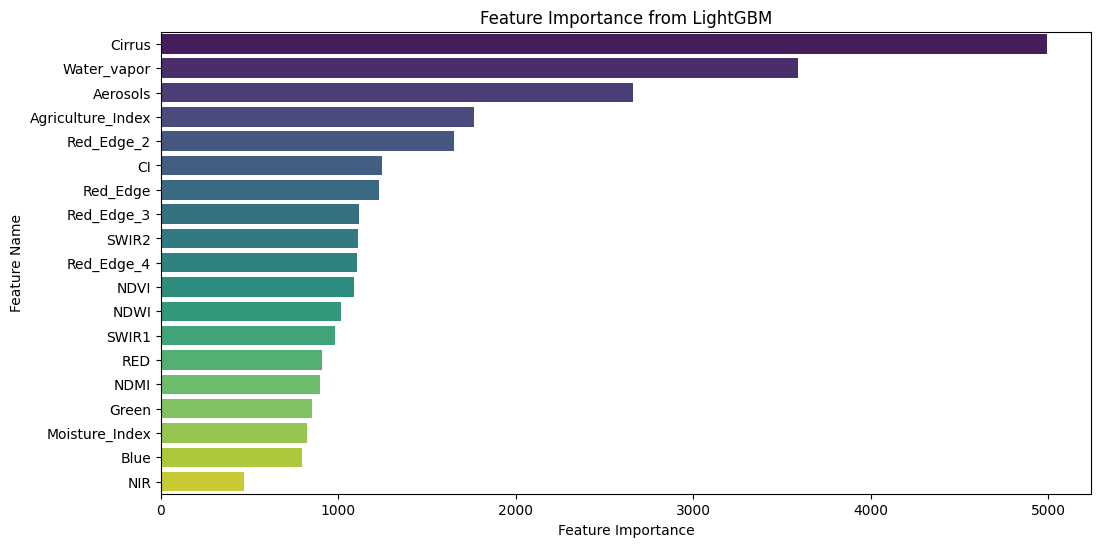

In [279]:
# Get best model from GridSearchCV

# Extract feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': feature_importances}
).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance from LightGBM')
plt.show()

In [281]:
# Save the submission file
submission.to_csv('optuna_goss_1.csv', index=False)